Input shape: (577, 60, 87)
Output shape (577, 60)
R² Scores for each output: [-2.927657470704012, -2.3351881920272577, -3.6455806288386317, -2.5083415086807896, -2.5143346111294487, -2.5306290997925385, -2.962467641071011, -3.811607683147983, -1.7696898231576252, -2.258498547534605, -2.709701569174375, -1.6512438662011282, -0.2897049645524894, -0.2638184128578589, -0.13150073391585226, -0.09390926389331455, -0.024392930199825358, -0.02567850892079404, -0.017360609288605167, -0.016195387003472783, -0.03892371910178727, -0.02026093512198157, -0.06301797611760063, 0.004837515754157806, -0.03557423543402827, -0.046727435857079724, 0.01628272903686423, -0.023476275068615493, -0.028882728980225814, -0.02200720169103998, -0.014588623378933407, -0.015967792037357986, -0.03735501127694363, 0.00603693632673441, -0.04253138371821619, -0.0759683529425983, -0.06061071638856208, -0.048970307009600145, -0.10950871067549572, -0.021297021779829395, -0.027822128829260828, -0.05936273962846883, -0.051819

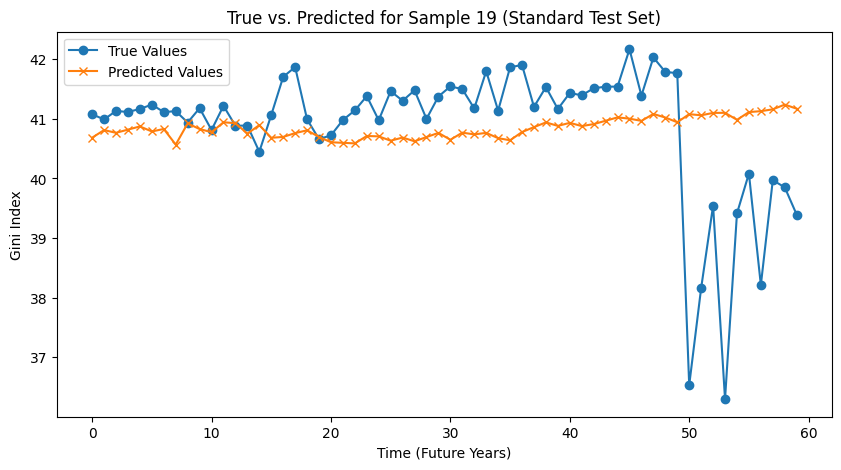

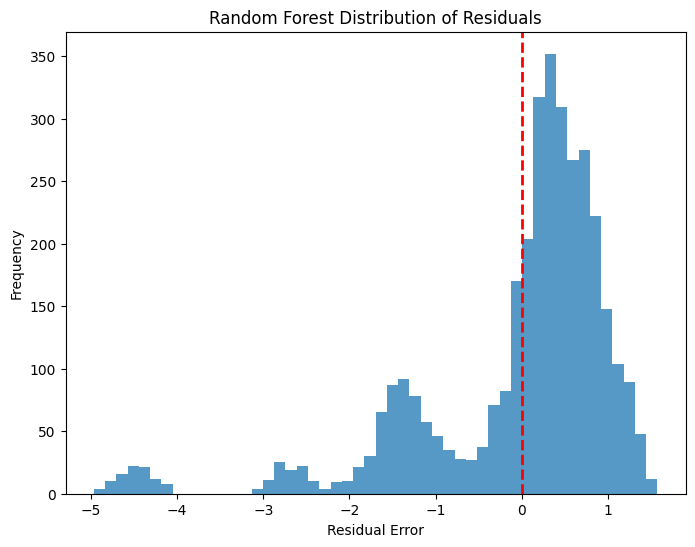

Model saved as 'shap_model.joblib'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

# Data Loading
def load_and_preprocess_data(file_path):
  return pd.read_csv(file_path)

def series_to_supervised(data, n_in=60, n_out=60):
  num_samples = len(data) - (n_in + n_out) + 1
  input_columns = [col for col in data.columns if col not in ['Gini Index']]
  X_list, y_list = [], []
  for start in range(num_samples):
    X_window = data.iloc[start: start + n_in][input_columns].values
    y_window = data.iloc[start + n_in: start + n_in + n_out]["Gini Index"].values
    X_list.append(X_window)
    y_list.append(y_window)
  X = np.array(X_list)
  y = np.array(y_list)
  return X, y

class FlattenTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    if X.ndim == 3:
      return X.reshape(X.shape[0], -1)
    return X

# Walk-Forward Validation
def walk_forward_validation(X, y, pipeline, n_test):
  predictions = []
  train_size = len(X) - n_test
  X_train, X_test = X[:train_size], X[train_size:]
  y_train, y_test = y[:train_size], y[train_size:]

  #History initiation
  history_X = list(X_train)
  history_y = list(y_train)

  for i in range(len(X_test)):
    testX = X_test[i:i+1]
    testy = y_test[i]

    pipeline.fit(np.array(history_X), np.array(history_y))

    yhat = pipeline.predict(testX)[0]
    predictions.append(yhat)

    history_X.append(testX[0])
    history_y.append(testy)

    print(f'>Expected: {testy}, Predicted {yhat}')

  mae = mean_absolute_error(y_test, predictions)
  rmse = root_mean_squared_error(y_test, predictions)
  return mae, rmse, y_test, np.array(predictions)


# Main Pipeline

def process_time_series_regression(file_path, n_test=20):
  data = load_and_preprocess_data(file_path)

  X,y = series_to_supervised(data, n_in=60, n_out=60)
  print('Input shape:', X.shape)
  print('Output shape', y.shape)

  y = SimpleImputer(strategy='mean').fit_transform(y)

  full_pipeline = Pipeline([
      ('flatten', FlattenTransformer()),
      ('imputer', SimpleImputer(strategy='mean')),
      ('scaler', MinMaxScaler()),
      ('model', MultiOutputRegressor(RandomForestRegressor(
          n_estimators=100,
          max_features='sqrt',
          max_depth=12,
          min_samples_split=5,
          min_samples_leaf=2,
          bootstrap=True,
          oob_score=True,
          random_state=42,
          n_jobs=-1
      )))
  ])

  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1,shuffle=False, random_state=42
  )

  full_pipeline.fit(X_train, y_train)
  y_pred = full_pipeline.predict(X_test)

  r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
  print('R² Scores for each output:', r2_scores)
  print('Mean R² Score:', np.mean(r2_scores))

  mae_scores = [mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
  rmse_scores = [np.sqrt(root_mean_squared_error(y_test[:, i], y_pred[:, i])) for i in range(y_test.shape[1])]
  print("Mean Absolute Error:", mae_scores)
  print("Mean MAE:", np.mean(mae_scores))
  print("Root Mean Squared Error:", rmse_scores)
  print("Mean RMSE:", np.mean(rmse_scores))

  # Walk-Forward Validation
  print("\nPerforming Walk-Forward Validation:")
  wf_mae, wf_rmse, wf_y_test, wf_predictions = walk_forward_validation(X, y, full_pipeline, n_test=n_test)
  print("Walk-Forward Validation MAE:", wf_mae)
  print("Walk-Forward Validation RMSE:", wf_rmse)

  # Visualization on Standard Test Set
  index = 19  # Change index to visualize different samples from the test set
  plt.figure(figsize=(10, 5))
  plt.plot(range(len(y_test[index])), y_test[index], label="True Values", marker='o')
  plt.plot(range(len(y_pred[index])), y_pred[index], label="Predicted Values", marker='x')
  plt.xlabel("Time (Future Years)")
  plt.ylabel("Gini Index")
  plt.title(f"True vs. Predicted for Sample {index} (Standard Test Set)")
  plt.legend()
  plt.show()

  residuals = y_test - y_pred
  plt.figure(figsize=(8, 6))
  plt.hist(residuals.flatten(), bins=50, alpha=0.75)
  plt.axvline(x=0, color='r', linestyle='dashed', linewidth=2)
  plt.xlabel("Residual Error")
  plt.ylabel("Frequency")
  plt.title("Random Forest Distribution of Residuals")
  plt.show()

  # Save the pipeline
  joblib.dump(full_pipeline, 'shap_model.joblib')
  print("Model saved as 'shap_model.joblib'")

  # List of PCA-based feature names
  feature_names_pca = [f'PC{i+1}' for i in range(scaled_X_test.shape[1])]
  return full_pipeline

file_path = r"/content/Copy of BUDGET-2025-DB-2.xlsx - Normalized Train (2).csv"
model_pipeline = process_time_series_regression(file_path, n_test=20)

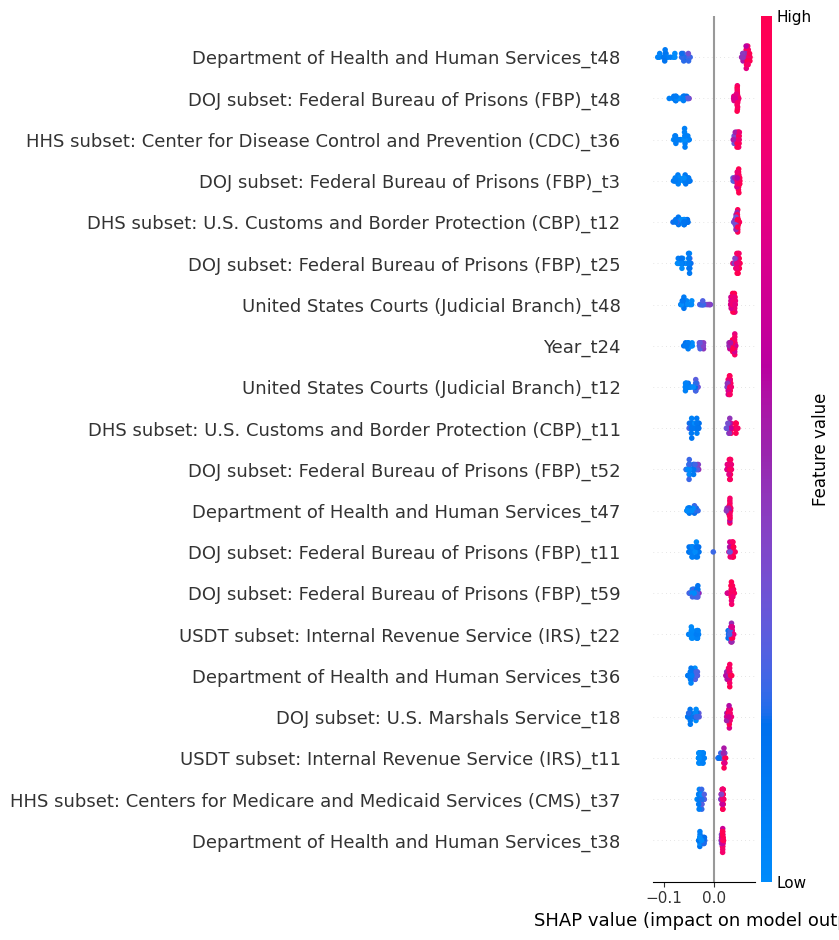

In [ ]:
import joblib
import shap
import pandas as pd


class FlattenTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    if X.ndim == 3:
      return X.reshape(X.shape[0], -1)
    return X

# Load pipeline and dataset
model_pipeline = joblib.load("/content/shap_model.joblib")
data = pd.read_csv(r"/content/Copy of BUDGET-2025-DB-2.xlsx - Normalized Train (2).csv")

# Define features
original_features = [col for col in data.columns if col not in ['Gini Index']]

# Supervised function
def series_to_supervised(data, n_in=60, n_out=60):
    num_samples = len(data) - (n_in + n_out) + 1
    input_columns = [col for col in data.columns if col not in ['Gini Index']]
    X_list, y_list = [], []
    for start in range(num_samples):
        X_window = data.iloc[start: start + n_in][input_columns].values
        y_window = data.iloc[start + n_in: start + n_in + n_out]["Gini Index"].values
        X_list.append(X_window)
        y_list.append(y_window)
    return np.array(X_list), np.array(y_list)

X_sw, y_sw = series_to_supervised(data, n_in=60, n_out=60)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_sw, y_sw, test_size=0.1, random_state=42)

# Flatten and scale X_test
flattened_X_test = model_pipeline.named_steps['flatten'].transform(X_test)
scaled_X_test = model_pipeline.named_steps['scaler'].transform(flattened_X_test)

# SHAP values for the first estimator
rf_estimator = model_pipeline.named_steps['model'].estimators_[0]
explainer = shap.TreeExplainer(rf_estimator)
shap_values = explainer.shap_values(scaled_X_test)
flattened_X_test_df = pd.DataFrame(scaled_X_test, columns=[f'{feat}_t{i}' for i in range(60) for feat in original_features])
shap.summary_plot(shap_values, flattened_X_test_df)
# Plot SHAP summary

In [ ]:
print(type(shap_values), len(shap_values))
print(type(shap_values[0]), getattr(shap_values[0], "shape", "no shape"))

<class 'numpy.ndarray'> 58
<class 'numpy.ndarray'> (5220,)


In [ ]:
# Collect SHAP values
import shap
all_shap_values = []
for est in model_pipeline.named_steps['model'].estimators_:
    explainer = shap.TreeExplainer(est)
    shap_vals = explainer.shap_values(scaled_X_test)  # shape: (n_samples, n_features)
    all_shap_values.append(shap_vals)  # take abs to use for feature importance

In [ ]:
# all_shap_values to list of 2D arrays (n_samples, n_features)
shap_array = np.stack(all_shap_values, axis=0)  # shape: (n_outputs, n_samples, n_features)
shap_mean = shap_array.mean(axis=0)  # shape: (n_samples, n_features)

In [ ]:
n_timesteps = 60
n_total_features = shap_mean.shape[1]
n_base_features = n_total_features // n_timesteps

shap_3d = shap_mean.reshape(shap_mean.shape[0], n_timesteps, n_base_features)
shap_per_feature = shap_3d.mean(axis=1)  # shape: (n_samples, n_base_features)

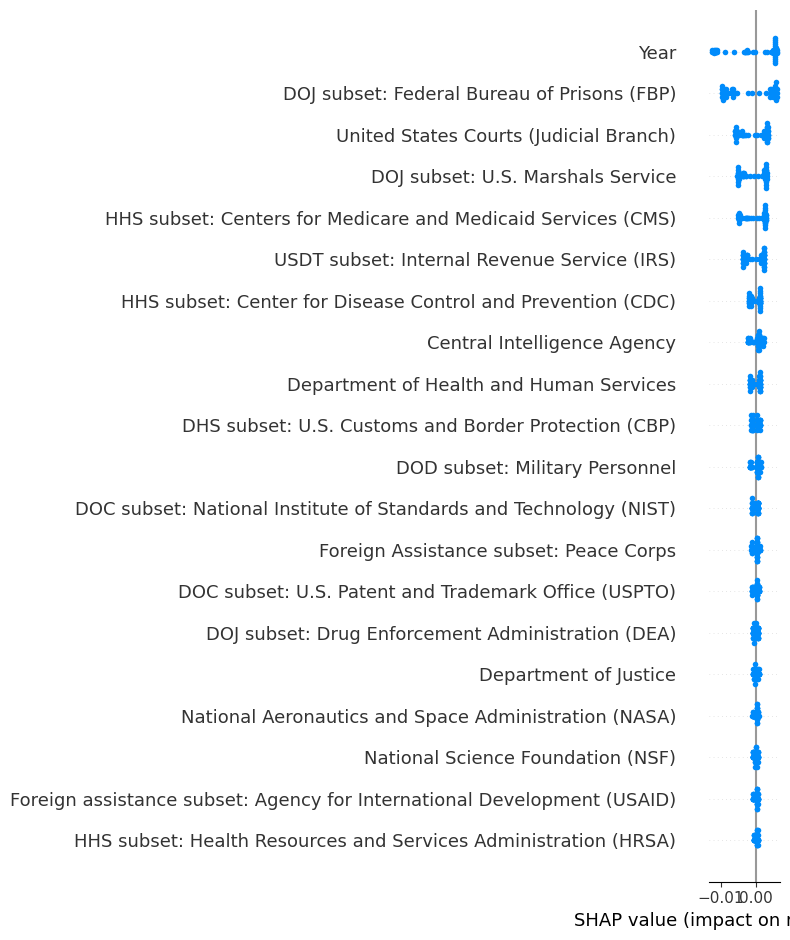

In [ ]:
shap.summary_plot(shap_per_feature, feature_names=original_features)

In [ ]:
import pandas as pd

shap_df = pd.DataFrame(shap_per_feature, columns=original_features)

shap_df.to_excel("shap_per_feature.xlsx", index=False)